### Import Required Libraries

In [7]:
"""
Explainable Image Classification on CIFAR-10

This notebook implements the complete pipeline for 
1. Model Selection and Training (ResNet-50)
2. Data Preprocessing (CIFAR-10)
3. Fine-Tuning with Transfer Learning
4. XAI Explanations (Grad-CAM and LIME)
"""
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS (Apple Silicon GPU) available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: False
MPS (Apple Silicon GPU) available: True
MPS built: True


### Device Setup

In [8]:
def setup_device():
    """
    Configure the computation device for optimal performance.
    
    Device Priority:
    1. MPS (Metal Performance Shaders) - Apple Silicon GPU (M1/M2/M3)
    2. CUDA - NVIDIA GPU
    3. CPU - Fallback option
    
    Returns:
        torch.device: The device to be used for tensor operations
    """
    # Check for Apple Silicon GPU (MPS)
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print("Using: Apple Silicon GPU (Metal Performance Shaders)")
        print("✓ M1/M2/M3/M4 GPU acceleration enabled")
        print("✓ Unified memory architecture optimized")
    # Check for NVIDIA GPU (CUDA)
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print(f"Using: NVIDIA GPU - {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print("✓ CUDA acceleration enabled")
    # Fallback to CPU
    else:
        device = torch.device("cpu")
        print("\n" + "="*80)
        print("DEVICE CONFIGURATION")
        print("="*80)
        print("Using: CPU")
        print("⚠️ GPU acceleration not available - training will be slower")
        print("Consider using Google Colab for free GPU access")
    
    print("="*80)
    return device

# Initialize device
device = setup_device()


DEVICE CONFIGURATION
Using: Apple Silicon GPU (Metal Performance Shaders)
✓ M1/M2/M3/M4 GPU acceleration enabled
✓ Unified memory architecture optimized


### Dataset Loadin and Preprocessing 

In [9]:
def load_cifar10_data(batch_size=64, num_workers=0):
    """
    Load and preprocess CIFAR-10 dataset for ResNet-50.
    
    Dataset: 60,000 images (32×32) in 10 classes
    Preprocessing: Resize to 224×224, ImageNet normalization
    Split: 40k train / 10k validation / 10k test
    
    Args:
        batch_size (int): Samples per batch (64 optimal for M1)
        num_workers (int): Data loading threads (0 for MPS)
    
    Returns:
        tuple: (train_loader, val_loader, test_loader, class_names)
    """
    # ImageNet normalization constants
    # RGB channel means: Red=0.485, Green=0.456, Blue=0.406
    mean = [0.485, 0.456, 0.406]
    # RGB channel standard deviations: Red=0.229, Green=0.224, Blue=0.225
    std = [0.229, 0.224, 0.225]

   # Training augmentation pipeline (increases dataset diversity, prevents overfitting)
    train_transform = transforms.Compose([
        transforms.Resize(224),  # Resize to 224×224
        transforms.RandomHorizontalFlip(p=0.5),  # Flip 50% of images horizontally
        transforms.RandomCrop(224, padding=4),   # Random crop with 4-pixel padding for slight variations
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness/contrast adjustment (±20%)n
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean, std)  # Normalize using ImageNet statistics (required for pretrained models)
    ])
    # Validation/test transform (no augmentation, only preprocessing)
    test_transform = transforms.Compose([
        transforms.Resize(224), # Resize to 224×224
        transforms.ToTensor(), # Convert to tensor [0, 1]
        transforms.Normalize(mean, std) # Normalize using ImageNet statistics
    ])
    # Download CIFAR-10
    print("Loading CIFAR-10 dataset...")
    train_val_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    
    test_dataset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    # Split train into train/val (80/20)
    train_size = int(0.8*len(train_val_dataset)) # 40,000 training samples
    val_size = len(train_val_dataset) - train_size # 10,000 validation samples
    # Perform random split with fixed seed for reproducibility
    train_dataset, val_dataset = random_split(
        train_val_dataset, # Dataset to split (50,000 images)
        [train_size, val_size], # Split sizes [40,000, 10,000]
        generator=torch.Generator().manual_seed(42) # Fixed seed for reproducible splits
    )

    # Apply test transform to validation set (remove augmentation)
    # Validation should not have data augmentation like training set
    val_dataset.dataset = datasets.CIFAR10(
        root='./data',
        train=True, # Use training set pool
        download=False,
        transform=test_transform # Apply test transform (no augmentation)
    )

    # Create training data loader (shuffled batches for training)
    train_loader = DataLoader(
        train_dataset, # Training dataset (40,000 samples)
        batch_size=batch_size, # Number of samples per batch (64)
        shuffle=True, # Shuffle data every epoch (prevents learning order)
        num_workers=num_workers, # Number of subprocesses for data loading
        pin_memory=False  # Not needed for MPS
    )
    # Create validation data loader (no shuffling needed)
    val_loader = DataLoader(
        val_dataset, # Validation dataset (10,000 samples)
        batch_size=batch_size, # Batch size (64)
        shuffle=False, # No shuffling for validation (order doesn't matter)
        num_workers=num_workers,# Data loading threads (0)
        pin_memory=False # Not needed for MPS
    )
    # Create test data loader (no shuffling needed)
    test_loader = DataLoader(
        test_dataset, # Test dataset (10,000 samples)
        batch_size=batch_size, # Batch size (64)
        shuffle=False, # No shuffling for test set
        num_workers=num_workers, # Data loading threads (0)
        pin_memory=False # Not needed for MPS
    )

    # Class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"  Training samples: {len(train_dataset):,}")
    print(f"  Validation samples: {len(val_dataset):,}")
    print(f"  Test samples: {len(test_dataset):,}")
    print(f"  Number of classes: {len(classes)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Image size: 224×224×3")
    print(f"  Normalization: mean={mean}, std={std}")
    
    return train_loader, val_loader, test_loader, classes
# Load CIFAR-10 data
train_loader, val_loader, test_loader, class_names = load_cifar10_data(batch_size=64, num_workers=0)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified

Dataset Statistics:
  Training samples: 40,000
  Validation samples: 10,000
  Test samples: 10,000
  Number of classes: 10
  Batch size: 64
  Image size: 224×224×3
  Normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


### Visualize Sample Images


Visualizing training samples:


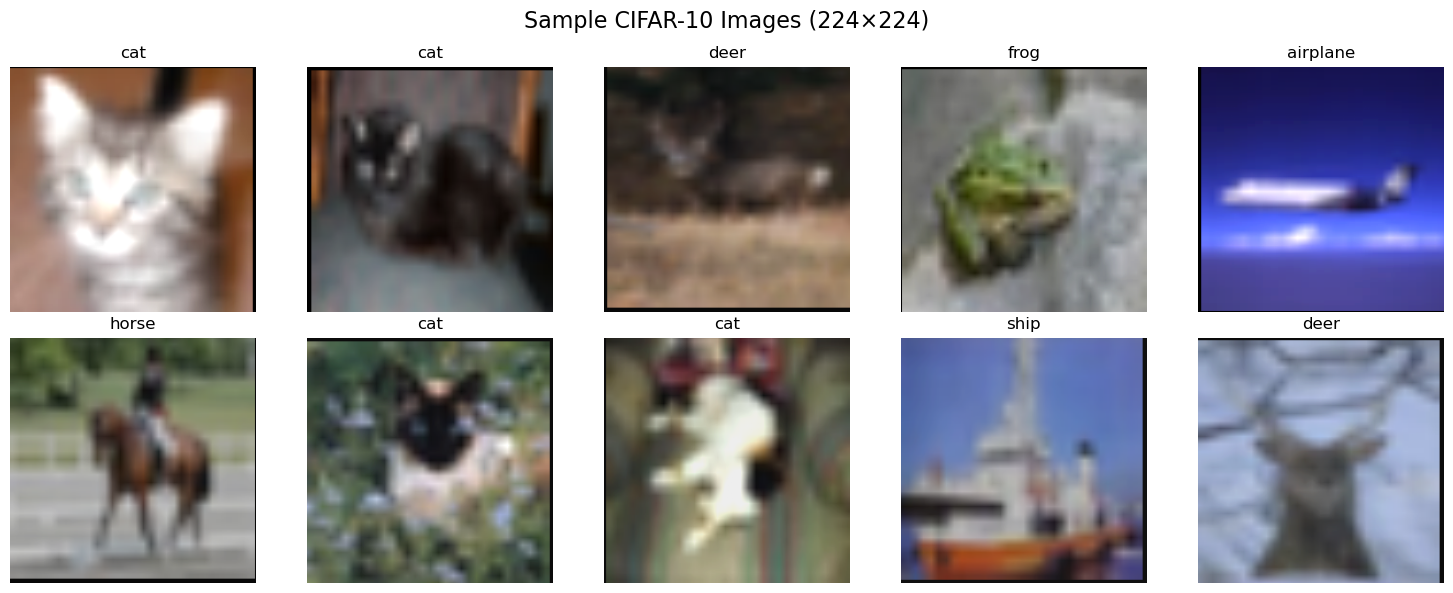

In [10]:
def visualize_cifar10_samples(loader, classes, num_samples=10):
    """
    Display random CIFAR-10 samples after preprocessing.
    
    Args:
        loader (DataLoader): Data loader
        classes (list): Class names
        num_samples (int): Number of samples to display
    """
    # Get batch
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Denormalization constants
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample CIFAR-10 Images (224×224)', fontsize=16)
    
    for idx in range(num_samples):
        ax = axes[idx // 5, idx % 5]
        
        # Denormalize
        img = images[idx] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        # Display
        ax.imshow(img)
        ax.set_title(f'{classes[labels[idx]]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
print("\nVisualizing training samples:")
visualize_cifar10_samples(train_loader, class_names)

### Load Pretrained ResNet-50

In [11]:
def load_pretrained_resnet50(num_classes=10, pretrained=True):
    """
    Load ResNet-50 pretrained on ImageNet and adapt for CIFAR-10.
    
    Architecture: 50 layers with bottleneck residual blocks
    Parameters: ~25.6 million
    Pretrained: ImageNet (1.2M images, 1000 classes)
    
    Args:
        num_classes (int): Output classes (10 for CIFAR-10)
        pretrained (bool): Load ImageNet weights
    
    Returns:
        nn.Module: Modified ResNet-50
    """
    print("Loading ResNet-50 model...")
    
    # Load pretrained model
    if pretrained:
        # Load ResNet-50 with ImageNet pretrained wights (1000 classes)
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        print("  ✓ Loaded ImageNet pretrained weights")
    else:
        # Load ResNet-50 with random initialization (no pretrained weights)
        model = models.resnet50(weights=None)
        print("  ✓ Initialized with random weights")
    
    # Replace final fully connected layer for CIFAR-10 (1000 classes → 10 classes)
    # Get input features for the original FC layer (2048 for ResNet-50)
    num_features = model.fc.in_features
    # Replaec FC layer: 2048 input features -> 10 output classes 
    model.fc = nn.Linear(num_features,num_classes)
    print(f"\n  ✓ Replaced FC layer: {num_features} → {num_classes} classes")

    # Calaculate total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters())
    # Calculate trainable parameter only 
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nParameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")
    print(f"  Model size: ~{total_params * 4 / (1024**2):.1f} MB")
    
    return model

# Load ResNet-50 with pretrained ImageNet weights
model = load_pretrained_resnet50(num_classes=10, pretrained=True)
# Move model to the configured device (MPS/CUDA/CPU)
model = model.to(device)

Loading ResNet-50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/thomasheim/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]


  ✓ Loaded ImageNet pretrained weights

  ✓ Replaced FC layer: 2048 → 10 classes

Parameters:
  Total: 23,528,522
  Trainable: 23,528,522
  Model size: ~89.8 MB


### Training Configuration 


In [12]:
def configure_training(model, learning_rate=0.001):
    """
    Configure loss function, optimizer, and learning rate scheduler.
    
    Strategy: Fine-tune all layers with Adam optimizer
    Loss: CrossEntropyLoss for multi-class classification
    Scheduler: ReduceLROnPlateau (reduce LR when validation loss plateaus)
    
    Args:
        model (nn.Module): The model to train
        learning_rate (float): Initial learning rate
    
    Returns:
        tuple: (criterion, optimizer, scheduler)
    """
    # Define loss function for multi-class classification
    # CrossEntropyLoss combines LogSoftmax and NLLLoss
    criterion = nn.CrossEntropyLoss()
    
    # Configure Adam optimizer (adaptive learning rate optimization)
    # Optimizes all model parameters (full fine-tuning)
    optimizer = optim.Adam(
        # All model parameters will be updated
        model.parameters(),
        # Initial learning rate
        lr=learning_rate,
        # Weight decay for L2 regularization (prevents overfitting)
        weight_decay=1e-4
    )
    
    # Learning rate scheduler (reduces LR when validation loss plateaus)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        # Optimizer to adjust
        optimizer,
        # Minimize validation loss
        mode='min',
        # Reduce LR by factor of 0.1 when plateau detected
        factor=0.1,
        # Wait 3 epochs before reducing LR
        patience=3,
        # Verbose output when LR changes
        verbose=True
    )
    
    print("\n" + "="*80)
    print("TRAINING CONFIGURATION")
    print("="*80)
    print(f"Loss Function: CrossEntropyLoss")
    print(f"Optimizer: Adam")
    print(f"Learning Rate: {learning_rate}")
    print(f"Weight Decay: 1e-4")
    print(f"LR Scheduler: ReduceLROnPlateau (factor=0.1, patience=3)")
    print(f"Training Strategy: Full fine-tuning (all layers trainable)")
    print("="*80)
    
    return criterion, optimizer, scheduler

# Configure training components
criterion, optimizer, scheduler = configure_training(model, learning_rate=0.001)


TRAINING CONFIGURATION
Loss Function: CrossEntropyLoss
Optimizer: Adam
Learning Rate: 0.001
Weight Decay: 1e-4
LR Scheduler: ReduceLROnPlateau (factor=0.1, patience=3)
Training Strategy: Full fine-tuning (all layers trainable)


/opt/anaconda3/envs/in3050/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training Functions

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Process:
    1. Set model to training mode
    2. Iterate through batches
    3. Forward pass → compute loss → backward pass → update weights
    4. Track loss and accuracy
    
    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to use (MPS/CUDA/CPU)
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    # Set model to training mode 
    model.train()
    running_loss = 0.0
    correct = 0 # Correct predictions counter
    total = 0

    # Create progress bar for training batches
    train_pbar = tqdm(train_loader, desc='Training', leave=False)

    # Iterate trhough traning batches 
    for inputs, labels in train_pbar:
        # Move inputs for device 
        inputs = inputs.to(device)
        # Move labels to device
        labels = labels.to(device)

        # Zero the parameter gradients (clear previous gradients)
        optimizer.zero_grad()
        # Forward pass. compute model predicitons
        outputs = model(inputs)
        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)
        # Backward pass: compute gradients 
        loss.backward()
        # Update model parameters using computed gradients
        optimizer.step()

        # Accumulate loss 
        running_loss += loss.item() * inputs.sieze(0)

        # Calculate accuracy 
        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs,1)
        # Count total samples in batch
        total += labels.size(0)
        # Count correct predictions 
        correct += (predicted == labels).sum().item()

        # Update progress bar with current metrics
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct / total:.2f}%'
        })
    # Calculate epoch metric
    # Average loss across all samples
    epoch_loss = running_loss / total
    # Accuracy as perchentage
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc
